<a href="https://colab.research.google.com/github/alibekk93/project-protein_folding_distances/blob/colab_v3/SS_and_expression_systems_noFilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a **Colab** implementation of the code for **SS_and_expression_systems** project

The code consists of several parts:

1.   **Data preprocessing** - we use [PDB's ss.txt file](https://cdn.rcsb.org/etl/kabschSander/ss.txt.gz) to create a csv file with AA and SS sequences in a table format for all available entries
2.   **FASTA files creation** - using PDB's advanced search, we found IDs of each protein source / expression system pair and saved the results in .csv format. We combine the .csv files with the preprocessed SS_data_processed datafile (d_processed) to obtain AA of these entities and save them in .FAS format. Separate files are made for *E. coli* and "native" expression systems
3.   **BLASTp** - this step is performed in [DAMBE](http://dambe.bio.uottawa.ca/DAMBE/dambe.aspx)
3.   **BLASTp results filtering** - we load the results of BLASTp ran in DAMBE and filter them
4.   **Data files creation** - we use filtered BLASTp results to create a separate data file for each protein database. Each Protein origin species / Expression system pair has a separate database
5.   **Matrix creation** - for each resampled data file we create a count matrix with AA /SS pairs
6.   **Matrix comparison** - matrices are compared visually and JS divergencies are calculated between them
7.   **Statistical analysis** - we compare JS divergencies between different data files. We obtain median JS divergencies to  compare effect of having *E. coli* as an expression system for proteins from different source organisms. We use bootstrapping to obtain confidence intervals and permutation to test null hypothesis that JS divergencies are not correlated with protein source species

In [1]:
!git clone -b colab_v3 https://github.com/alibekk93/project-protein_folding_distances

Cloning into 'project-protein_folding_distances'...
remote: Enumerating objects: 614, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 614 (delta 78), reused 191 (delta 59), pack-reused 395
Receiving objects: 100% (614/614), 53.19 MiB | 11.01 MiB/s, done.
Resolving deltas: 100% (225/225), done.


# Set-up

In [2]:
# essential ones:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.lines import Line2D
import seaborn as sns

# files handling in Colab:
from google.colab import files
from io import StringIO

# loop iteration visualization:
from tqdm import tqdm

SS_types_mapping = {'I':'H', 'G':'H',
                    'B':'E',
                    'S':'C', 'T':'C'}

entity_id_mapping = {integer+1:letter for integer, letter in enumerate('ABCDEFGHIJKLMNOPQRSTUVWXYZ')}

species_names = ['Bacillus subtilis', 'Desulfovibrio vulgaris',
                 'Lactococcus lactis', 'Pseudomonas fluorescens',
                 'Pseudomonas putida', 'Salmonella enterica', 'Streptomyces rubiginosus', 'Thermus thermophilus'
                 ]

species_names_short = [species_name[0] + species_name.split(' ')[1] for species_name in species_names]
species_names_veryshort = [species_name[0] + '. ' + species_name[1:] for species_name in species_names_short]

AA_types = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','X','Y']
SS8_types = ['H','I','G','E','B','C','S','T']
SS3_types = ['H','E','C']

In [3]:
# Upload files - only do this if you already prepared them
protein_SS_df = pd.read_pickle('/content/project-protein_folding_distances/results/protein_SS_df.pkl')
resampled_data = pd.read_pickle('/content/project-protein_folding_distances/results/resampled_data.pkl')
ci_df_long = pd.read_pickle('/content/project-protein_folding_distances/results/ci_df_long.pkl')

In [4]:
def change_to_SS3(count_matrix_8):
  count_matrix_8 = count_matrix_8.T
  count_matrix_3 = pd.DataFrame(np.zeros((len(AA_types), len(SS3_types))), columns=SS3_types, index=AA_types)
  count_matrix_3.H = count_matrix_8.H + count_matrix_8.I + count_matrix_8.G
  count_matrix_3.E = count_matrix_8.E + count_matrix_8.B
  count_matrix_3.C = count_matrix_8.C + count_matrix_8.S + count_matrix_8['T']
  return count_matrix_3.T

# Data preprocessing

We use [PDB's ss.txt file](https://cdn.rcsb.org/etl/kabschSander/ss.txt.gz) to create a csv file with AA and SS sequences in a table format for all available entries

The table would be more eficient for later tasks than the original file

In this file coil SS are repreneted by spaces, " ", we need to replace the spaces with "C"

## Download the ss.txt file

In [4]:
!gunzip /content/project-protein_folding_distances/ss.txt.gz

In [5]:
with open('/content/project-protein_folding_distances/ss.txt', 'r', encoding='utf-8') as f:
  d_lines = f.read().splitlines()

## Separate lines in 3 lists and form a dataframe:

1.   **seq_names** - sequence names list
2.   **AA_seqs** - AA sequences list
3.   **SS_seqs** - SS sequences list


This is tricky because sequences can occupy various number of lines. We will need to utilize the **'>'** characters to distinguish between sequence names and sequences. For each sequence, we will concatenate each line until the next **'>'** character. We will also have to iterate a variable **seq_type** to separate AA from SS

In [6]:
seq_names = []
AA_seqs = []
SS_seqs = []
seq_type = 'AA'
seq = ''        # we will concatenate sequences to this string

for line in d_lines[:-1]:                      # last line is empty, so we do not include it
  if line[0] == '>':                               # indicates sequence name
    if seq_type == 'AA':
      if seq != '':
        AA_seqs.append(seq)
        seq_type = 'SS'
        seq = ''
      seq_names.append(line[1:7])
    elif seq_type == 'SS':
      if seq != '':
        SS_seqs.append(seq.replace(' ','C'))
        seq_type = 'AA'
        seq = ''
      continue
  else:                                            # indicates sequence string
    seq += line
SS_seqs.append(seq.replace(' ','C'))               # append the last line

In [7]:
d_processed = pd.DataFrame({'AA_seq':AA_seqs, 'SS_seq':SS_seqs}, index=seq_names[1:])

In [15]:
for sn_s, sn_l in zip(species_names_short[:5], species_names[:5]):
  path = '/content/00_' + sn_s +'.csv'
  id_df = pd.read_csv(path)
  id_df.dropna(subset=['expression_host_sci_name'], inplace=True)
  id_df_native = id_df[id_df.expression_host_sci_name.str.contains(sn_l)][['pdb_id', 'entity_id']]
  id_df_recomb = id_df[id_df.expression_host_sci_name.str.contains('Escherichia coli')][['pdb_id', 'entity_id']]
  id_df_native.entity_id = id_df_native.entity_id.map({1:'A', 2:'B', 3:'C', 4:'D', 5:'E', 6:'F', 7:'G'})
  id_df_recomb.entity_id = id_df_recomb.entity_id.map({1:'A', 2:'B', 3:'C', 4:'D', 5:'E', 6:'F', 7:'G'})
  id_df_native['ID_full'] = id_df_native.pdb_id.str.upper() + ':' + id_df_native.entity_id
  id_df_recomb['ID_full'] = id_df_recomb.pdb_id.str.upper() + ':' + id_df_recomb.entity_id
  ids_native = [*id_df_native['ID_full']]
  ids_recomb = [*id_df_recomb['ID_full']]
  AA_native = ''
  SS_native = ''
  AA_recomb = ''
  SS_recomb = ''
  for idn in ids_native:
    try:
      AA_native += d_processed.loc[idn].AA_seq
      SS_native += d_processed.loc[idn].SS_seq
    except:
      continue
  for idr in ids_recomb:
    try:
      AA_recomb += d_processed.loc[idr].AA_seq
      SS_recomb += d_processed.loc[idr].SS_seq
    except:
      continue
  name_native = '06_' + sn_s + '_' + sn_s + '_datafile_ALL.fas'
  name_recomb = '06_' + sn_s + '_' + 'Ecoli' + '_datafile_ALL.fas'
  datafile_native = open(name_native, 'w')
  datafile_native.write('>AA\n')
  datafile_native.write(AA_native + '\n')
  datafile_native.write('>SS\n')
  datafile_native.write(SS_native)
  datafile_native.close()
  files.download(name_native)
  datafile_recomb = open(name_recomb, 'w')
  datafile_recomb.write('>AA\n')
  datafile_recomb.write(AA_recomb + '\n')
  datafile_recomb.write('>SS\n')
  datafile_recomb.write(SS_recomb)
  datafile_recomb.close()
  files.download(name_recomb)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# FASTA files creation

We need to create FASTA files so that we can run BLASTp using them. We used PDB's advances search to download protein IDs and entity numbers in .csv format and will combine those files with the preprocessed dataframe from the previous step

First, we load the .csv files

In [ ]:
uploaded = files.upload()

Saving 00_Hsalinarum.csv to 00_Hsalinarum.csv


We will process these files into FASTA files using a function

In [ ]:
def create_fasta(species_name, alt_expression_sys='Escherichia coli', d_processed=d_processed, download=True):
  '''
  Creates FASTA files with protein AA using a protein .csv file and a preprocessed dataframe of protein AA / SS
  species_name: protein host name
  alt_expression_sys: the non-native expression system of interest. E. coli by default
  d_processed: the processed protein AA / SS file
  download: if True will download the FASTA file
  '''
  # create names for the new files
  species_name_short = species_name[0] + species_name.split(' ')[1]
  alt_name_short = alt_expression_sys[0] + alt_expression_sys.split(' ')[1]
  protein_file_name = '00_' + species_name_short + '.csv'
  FASTA_name_1 = '02_' + species_name_short + '_' + species_name_short + '_AA.FAS'
  FASTA_name_2 = '02_' + species_name_short + '_' + alt_name_short + '_AA.FAS'
  
  # load the .csv file into a dataframe, drop NaNs
  ID_df = pd.read_csv(StringIO(str(uploaded[protein_file_name],'utf-8')))
  ID_df.dropna(subset=['expression_host_sci_name'], inplace=True)

  # filter expression systems
  df_1 = ID_df[ID_df.expression_host_sci_name.str.contains(species_name)]
  df_2 = ID_df[ID_df.expression_host_sci_name.str.contains(alt_expression_sys)]

  # create lists of IDs (with entities as A, B, C, etc)
  proteins_1 = [p_id.upper()+':'+entity_id_mapping[e_id] for p_id, e_id in zip(df_1.pdb_id, df_1.entity_id)]
  proteins_2 = [p_id.upper()+':'+entity_id_mapping[e_id] for p_id, e_id in zip(df_2.pdb_id, df_2.entity_id)]
  # drop protein IDs that are not in d_processed (this is rare, but sometimes happens for some reason)
  proteins_1 = [protein for protein in proteins_1 if protein in d_processed.index]
  proteins_2 = [protein for protein in proteins_2 if protein in d_processed.index]

  # create lists of AAs
  AAs_1 = [d_processed.loc[protein, 'AA_seq'] for protein in proteins_1]
  AAs_2 = [d_processed.loc[protein, 'AA_seq'] for protein in proteins_2]

  # create FASTA files and download
  with open(FASTA_name_1, mode='w') as f:
    for p_idx in range(len(proteins_1)):
      f.write('>'+proteins_1[p_idx]+'\n')
      f.write(AAs_1[p_idx]+'\n')
  
  with open(FASTA_name_2, mode='w') as f:
    for p_idx in range(len(proteins_2)):
      f.write('>'+proteins_2[p_idx]+'\n')
      f.write(AAs_2[p_idx]+'\n')
  
  if download==True:
    files.download(FASTA_name_1)
    files.download(FASTA_name_2)

In [ ]:
for species in species_names:
  print(species)
  create_fasta(species_name=species, alt_expression_sys='Escherichia coli', d_processed=d_processed, download=False)

Bacillus subtilis


KeyError: ignored

# BLASTp filtering

We use BLASTp results obtained in DAMBE. The results were saved as CSV files. We will filter the results to get PDB entries with same (or almost identical) AA sequences and different Expression systems

In [ ]:
uploaded = files.upload()

Saving 04_Hsalinarum_BLAST.csv to 04_Hsalinarum_BLAST.csv


In [ ]:
def filter_BLASTp(filename, download=False, min_match=95, min_len=50, max_e=0.01):
  '''
  BLASTp filtering, creation of a dataframe and optional saving of a CSV
  '''
  BLAST_results = pd.read_csv(StringIO(str(uploaded[filename],'utf-8')),sep=';')
  BLAST_results_filtered = BLAST_results[(BLAST_results['%Match'] >= min_match) &
                                         (BLAST_results['MatchLen'] >= min_len) &
                                         (BLAST_results['E-Val'] <= max_e)]
  BLAST_results_filtered = BLAST_results_filtered.reset_index().iloc[:,1:]
  if download == True:
    newname = filename.replace('04', '05').replace('.csv', '_results_filtered.csv')
    BLAST_results_filtered.to_csv(newname)
    files.download(newname)
  return BLAST_results_filtered

**filtered_BLASTps** dictionary will have all filtered BLASTp results stored as dataframes. The dataframes can also be downloaded as CSV files using the *'download=True'* option

In [ ]:
filtered_BLASTps = {}
db_names = ['BS', 'DV', 'LL', 'PF', 'PP', 'SE', 'SR', 'TT']
for filename, db_name in zip(uploaded.keys(), db_names):
  filtered_BLASTps[db_name] = filter_BLASTp(filename, download=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Data files creation

The entries names in BLASTp file need to be connected with the AA and SS sequences in the ss.txt file (which has been preprocessed into a dataframe).

A single Query entry can have multiple DB entries, separated by '_' symbol. Not only the DB entries need to be separated from each other, but the Query entries need to be multiplied so that each DB entry has a Query entry pair. The function below will tackle this issue

In [11]:
def create_data_file(filtered_BLASTp_file, db_name, q_name='Ecoli', download=False):
  '''
  Create a data file from the filtered BLASTp dataframe. Data files will have AA and SS sequences for all PDB entries in the BLASTp file in FASTA format

  Query and Database names need to be specified

  Optionally, the result file will be downloaded to the local disk
  '''
  # create lists
  DB_list = [filtered_BLASTp_file.loc[i,'DB_Seq'].split('_') for i in range(len(filtered_BLASTp_file))]    # list of DB sequences separated from each other
  multiplier_list = [filtered_BLASTp_file.loc[i,'DB_Seq'].count('_') + 1 for i in range(len(filtered_BLASTp_file))]    # list of integers to multiply Query entries
  Q_list = list(filtered_BLASTp_file['Query'])    # list of Query entries
  QS_list = list(filtered_BLASTp_file['QueryStart'].astype(int))    # list of Query start positions
  QE_list = list(filtered_BLASTp_file['QueryEnd'].astype(int))    # list of Query end positions
  DBS_list = list(filtered_BLASTp_file['DB_SeqStart'].astype(int))    # list of DB start positions
  DBE_list = list(filtered_BLASTp_file['DB_SeqEnd'].astype(int))    # list of DB end positions

  # create lines for Query entries
  Q_AA_line = ''
  Q_SS_line = ''
  for Q, QS, QE, mult in zip(Q_list, QS_list, QE_list, multiplier_list):
    AA_seq = d_processed.loc[Q]['AA_seq'][QS-1:QE]
    SS_seq = d_processed.loc[Q]['SS_seq'][QS-1:QE]
    Q_AA_line += ('*' + AA_seq) * mult
    Q_SS_line += ('*' + SS_seq) * mult

  # create lines for DB entries
  DB_AA_line = ''
  DB_SS_line = ''
  for DB, DBS, DBE in zip(DB_list, DBS_list, DBE_list):
    AA_line = ''
    SS_line = ''
    for DB_i in DB:
      AA_seq = d_processed.loc[DB_i]['AA_seq'][DBS-1:DBE]
      SS_seq = d_processed.loc[DB_i]['SS_seq'][DBS-1:DBE]
      AA_line += ('*' + AA_seq)
      SS_line += ('*' + SS_seq)
    DB_AA_line += AA_line
    DB_SS_line += SS_line

  # make data files with option to save in FASTA format
  datafiles = {}
  Q_data_file_name = '06_' + db_name + '_' + q_name + '_datafile.fas'
  DB_data_file_name = '06_' + db_name + '_' + db_name + '_datafile.fas'
  for n, aa, ss in zip([Q_data_file_name, DB_data_file_name],
                       [Q_AA_line, DB_AA_line],
                       [Q_SS_line, DB_SS_line]):
    datafiles[n] = open(n, 'w')
    datafiles[n].write('>AA\n')
    datafiles[n].write(aa + '\n')
    datafiles[n].write('>SS\n')
    datafiles[n].write(ss)
    datafiles[n].close()
    if download == True:
      files.download(n)

  return datafiles

In [ ]:
datafiles = {}
for BLASTp, species_name_short in zip(filtered_BLASTps.keys(), species_names_short):
  print(species_name_short)
  datafiles[species_name_short] = create_data_file(filtered_BLASTps[BLASTp], species_name_short, q_name='Ecoli', download=True)

NameError: ignored

In [ ]:
create_data_file(filtered_BLASTps['TT'], 'Tthermophilus', 'Ecoli', True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'06_Tthermophilus_Ecoli_datafile.fas': <_io.TextIOWrapper name='06_Tthermophilus_Ecoli_datafile.fas' mode='w' encoding='UTF-8'>,
 '06_Tthermophilus_Tthermophilus_datafile.fas': <_io.TextIOWrapper name='06_Tthermophilus_Tthermophilus_datafile.fas' mode='w' encoding='UTF-8'>}

Option to upload data files to avoid previous steps:

In [5]:
uploaded = files.upload()

datafiles = {}
f = 0
for i, species_name in enumerate(species_names_short):
  d = {}
  while f <= i*2:
    d[list(uploaded.keys())[f]] = uploaded[list(uploaded.keys())[f]].decode('utf-8').split('\n')
    d[list(uploaded.keys())[f+1]] = uploaded[list(uploaded.keys())[f+1]].decode('utf-8').split('\n')
    f += 2
  datafiles[species_name] = d

Saving 06_Bsubtilis_Bsubtilis_datafile_ALL.fas to 06_Bsubtilis_Bsubtilis_datafile_ALL.fas
Saving 06_Bsubtilis_Ecoli_datafile_ALL.fas to 06_Bsubtilis_Ecoli_datafile_ALL.fas
Saving 06_Dvulgaris_Dvulgaris_datafile_ALL.fas to 06_Dvulgaris_Dvulgaris_datafile_ALL.fas
Saving 06_Dvulgaris_Ecoli_datafile_ALL.fas to 06_Dvulgaris_Ecoli_datafile_ALL.fas
Saving 06_Llactis_Ecoli_datafile_ALL.fas to 06_Llactis_Ecoli_datafile_ALL.fas
Saving 06_Llactis_Llactis_datafile_ALL.fas to 06_Llactis_Llactis_datafile_ALL.fas
Saving 06_Pfluorescens_Ecoli_datafile_ALL.fas to 06_Pfluorescens_Ecoli_datafile_ALL.fas
Saving 06_Pfluorescens_Pfluorescens_datafile_ALL.fas to 06_Pfluorescens_Pfluorescens_datafile_ALL.fas
Saving 06_Pputida_Ecoli_datafile_ALL.fas to 06_Pputida_Ecoli_datafile_ALL.fas
Saving 06_Pputida_Pputida_datafile_ALL.fas to 06_Pputida_Pputida_datafile_ALL.fas
Saving 06_Senterica_Ecoli_datafile_ALL.fas to 06_Senterica_Ecoli_datafile_ALL.fas
Saving 06_Senterica_Senterica_datafile_ALL.fas to 06_Senterica_S

We will also create an Datafile class

In [6]:
class Datafile:
  """
  AA and SS sequences container
  """
  def __init__(self, source, expr_sys):
    self.source = source
    self.source_short = source[0] + source.split(' ')[1]
    self.expr_sys = expr_sys
    self.expr_sys_short = expr_sys[0] + expr_sys.split(' ')[1]
    self.fasta_file = datafiles[self.source_short]['06_%s_%s_datafile_ALL.fas' %(self.source_short, self.expr_sys_short)]
    self.AA_seq = self.fasta_file[1].replace('*', '')
    self.SS_seq = self.fasta_file[3].replace('*', '')
    self.SS_seq_3 = self.SS_seq.translate(str.maketrans(SS_types_mapping))
    self.len = len(self.AA_seq)

  def AA_count(self, aa):
    return self.AA_seq.count(aa)

  def SS_count(self, ss):
    return self.SS_seq.count(ss)

We will create a dataframe which will contain the original sequences and will be used to calculate JS divergence

In [7]:
AA_native_list = []
AA_recomb_list = []
SS_native_list = []
SS_recomb_list = []

for species_name in species_names:
  datafile_native = Datafile(source=species_name, expr_sys=species_name)
  AA_native_list.append(datafile_native.AA_seq)
  SS_native_list.append(datafile_native.SS_seq)
  datafile_recomb = Datafile(source=species_name, expr_sys='Escherichia coli')
  AA_recomb_list.append(datafile_recomb.AA_seq)
  SS_recomb_list.append(datafile_recomb.SS_seq)

protein_SS_df = pd.DataFrame({'AA_native':AA_native_list, 'SS_native':SS_native_list,
                              'AA_recomb':AA_recomb_list, 'SS_recomb':SS_recomb_list}, index=species_names)

# Count matrix creation

No we have data for every species with "native" and *E. coli* expression systems. We will create count matrices which will show how often each AA corresponds to each SS in the data file

The matrices will have fixed levels, because some rare AA and SS might not be in all data files

In [8]:
def get_count_matrix(AA_seq, SS_seq):

  AA_seq = np.array([*AA_seq])
  SS_seq = np.array([*SS_seq])

  counts = np.array([np.sum([aa==AA and ss==SS for aa, ss in zip(AA_seq, SS_seq)]) \
                     for SS in SS8_types for AA in AA_types]).reshape((len(SS8_types),len(AA_types)))

  count_matrix = pd.DataFrame(counts, columns=AA_types, index=SS8_types)

  return count_matrix

In [9]:
protein_SS_df['CM8_native'] = [*map(get_count_matrix, [AA_seq for AA_seq in protein_SS_df.loc[:, 'AA_native']],
                                    tqdm([SS_seq for SS_seq in protein_SS_df.loc[:, 'SS_native']]))]

 88%|████████▊ | 7/8 [00:05<00:00,  1.37it/s]


In [10]:
protein_SS_df['CM8_recomb'] = [*map(get_count_matrix, [AA_seq for AA_seq in protein_SS_df.loc[:, 'AA_recomb']],
                                    tqdm([SS_seq for SS_seq in protein_SS_df.loc[:, 'SS_recomb']]))]

 88%|████████▊ | 7/8 [01:58<00:16, 16.98s/it]


In [11]:
def change_to_SS3(count_matrix_8):
  count_matrix_8 = count_matrix_8.T
  count_matrix_3 = pd.DataFrame(np.zeros((len(AA_types), len(SS3_types))), columns=SS3_types, index=AA_types)
  count_matrix_3.H = count_matrix_8.H + count_matrix_8.I + count_matrix_8.G
  count_matrix_3.E = count_matrix_8.E + count_matrix_8.B
  count_matrix_3.C = count_matrix_8.C + count_matrix_8.S + count_matrix_8['T']
  return count_matrix_3.T

In [12]:
protein_SS_df['CM3_native'] = [*map(change_to_SS3, protein_SS_df.loc[:, 'CM8_native'])]
protein_SS_df['CM3_recomb']  = [*map(change_to_SS3, protein_SS_df.loc[:, 'CM8_recomb'])]

In [13]:
protein_SS_df.to_pickle('protein_SS_df.pkl')

In [14]:
files.download('protein_SS_df.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Matrix comparison

We will calculate [Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence) for each Protein origin species between matrices with "native" and *E. coli* Expression systems

In [15]:
def calculate_JS_matrix(matrix1, matrix2):
  matrix1 = (matrix1) / (matrix1).values.sum()
  matrix2 = (matrix2) / (matrix2).values.sum()
  matrix_both = (matrix1 + matrix2) / 2
  P = np.concatenate(matrix1.values)
  Q = np.concatenate(matrix2.values)
  M = np.concatenate(matrix_both.values)
  jsd_matrix1 = np.nan_to_num(P * np.log2(P / M))
  jsd_matrix2 = np.nan_to_num(Q * np.log2(Q / M))
  jsd_matrix = (jsd_matrix1 + jsd_matrix2) / 2
  return jsd_matrix.reshape(matrix1.shape)

In [16]:
protein_SS_df['JSD8_matrix'] = [*map(calculate_JS_matrix, protein_SS_df.loc[:, 'CM8_native'],
                                     protein_SS_df.loc[:, 'CM8_recomb'])]
protein_SS_df['JSD3_matrix']  = [*map(calculate_JS_matrix, protein_SS_df.loc[:, 'CM3_native'],
                                      protein_SS_df.loc[:, 'CM3_recomb'])]
protein_SS_df['JSD8'] = [*map(np.sum, protein_SS_df.JSD8_matrix)]
protein_SS_df['JSD3']  = [*map(np.sum, protein_SS_df.JSD3_matrix)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log2
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


In [17]:
protein_SS_df.loc[:, ['JSD8', 'JSD3']]

,JSD8,JSD3
Bacillus subtilis,0.030522,0.018853
Desulfovibrio vulgaris,0.039323,0.017415
Lactococcus lactis,0.039588,0.023227
Pseudomonas fluorescens,0.056719,0.037543
Pseudomonas putida,0.026864,0.012777
Salmonella enterica,0.067381,0.044045
Streptomyces rubiginosus,0.003566,0.000550
Thermus thermophilus,0.126449,0.097855


In [18]:
def plot_PM_heatmap(species_name, n_SS_types=8):
  if n_SS_types == 8:
    figsize = (7, 4)
    SS_types = SS8_types
  else:
    figsize = (7, 3)
    SS_types = SS3_types
  # get the matrices
  CM_native = protein_SS_df.loc[species_name, 'CM{ss}_native'.format(ss=n_SS_types)]
  CM_recomb = protein_SS_df.loc[species_name, 'CM{ss}_recomb'.format(ss=n_SS_types)]
  PM_native = CM_native / CM_native.sum().sum()
  PM_recomb = CM_recomb / CM_recomb.sum().sum()
  # get relevant JSD
  jsd = str(round(protein_SS_df.loc[species_name, 'JSD{ss}'.format(ss=n_SS_types)], 5))
  # plot heatmap
  plt.subplots(figsize=figsize)
  cbar_kws = {'orientation': 'horizontal'}
  sns.heatmap(PM_native - PM_recomb,
              linewidth=0.5, center=0, cmap=sns.diverging_palette(10, 200, sep=50, as_cmap=True),
              xticklabels=AA_types, yticklabels=SS_types, square=True,
              vmax=0.04, vmin=-0.04, cbar_kws=cbar_kws)
  plt.title(species_name, style='italic', fontsize=15)
  plt.annotate('JSD = ' + jsd, (0,0), fontsize=13)
  plt.show()

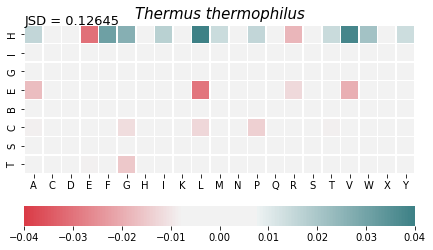

In [19]:
plot_PM_heatmap(species_name='Thermus thermophilus', n_SS_types=8)

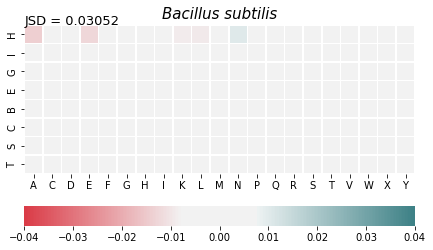

In [20]:
plot_PM_heatmap(species_name='Bacillus subtilis', n_SS_types=8)

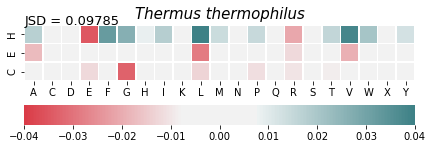

In [21]:
plot_PM_heatmap(species_name='Thermus thermophilus', n_SS_types=3)

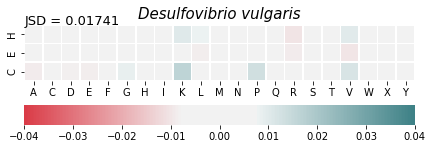

In [22]:
plot_PM_heatmap(species_name='Desulfovibrio vulgaris', n_SS_types=3)

In [23]:
sns.diverging_palette(10, 200, sep=50, as_cmap=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  app.launch_new_instance()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

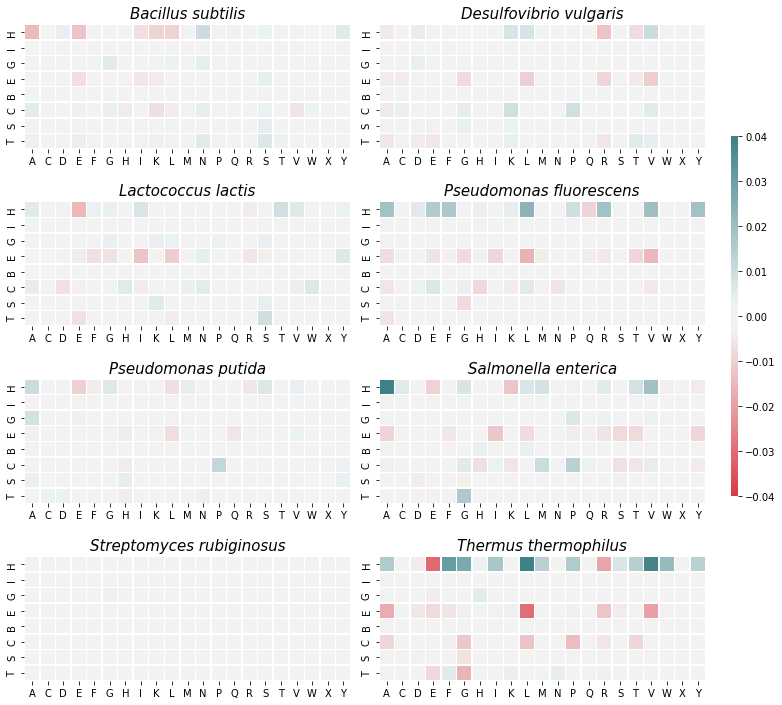

In [24]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize = (10, 10))
cbar_ax = fig.add_axes([1.02, .3, .01, .5])
for i, ax in enumerate(axs.flatten()):
  species_name = protein_SS_df.index[i]
  # get the matrices
  CM_native = protein_SS_df.loc[species_name, 'CM8_native']
  CM_recomb = protein_SS_df.loc[species_name, 'CM8_recomb']
  PM_native = CM_native / CM_native.sum().sum()
  PM_recomb = CM_recomb / CM_recomb.sum().sum()
  # plot heatmap
  sns.heatmap(PM_native - PM_recomb, ax=ax,
              linewidth=0.5, center=0, cmap=sns.diverging_palette(10, 200, sep=20, as_cmap=True),
              xticklabels=AA_types, yticklabels=SS8_types, square=True,
              vmax=0.04, vmin=-0.04, cbar=i==0, cbar_ax=None if i else cbar_ax)
  ax.set_title(species_name, style='italic', fontsize=15)
fig.tight_layout()
#plt.show()
plt.savefig('Heatmaps8_all.jpg', bbox_inches='tight', dpi=300)
files.download('Heatmaps8_all.jpg')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  app.launch_new_instance()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

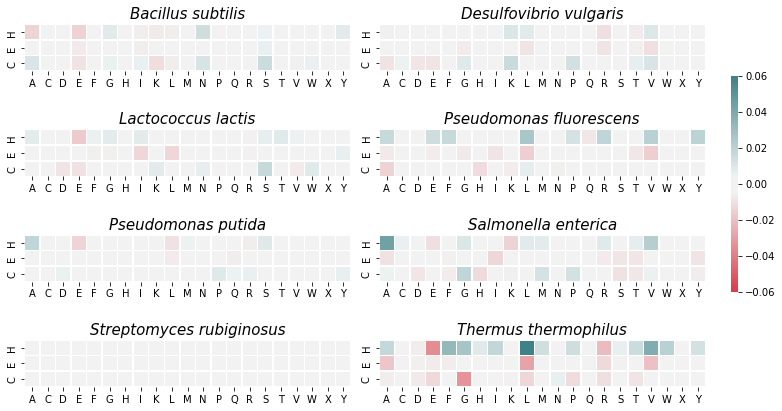

In [25]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize = (10, 6))
cbar_ax = fig.add_axes([1.02, .3, .01, .5])
for i, ax in enumerate(axs.flatten()):
  species_name = protein_SS_df.index[i]
  # get the matrices
  CM_native = protein_SS_df.loc[species_name, 'CM3_native']
  CM_recomb = protein_SS_df.loc[species_name, 'CM3_recomb']
  PM_native = CM_native / CM_native.sum().sum()
  PM_recomb = CM_recomb / CM_recomb.sum().sum()
  # plot heatmap
  sns.heatmap(PM_native - PM_recomb, ax=ax,
              linewidth=0.5, center=0, cmap=sns.diverging_palette(10, 200, sep=20, as_cmap=True),
              xticklabels=AA_types, yticklabels=SS3_types, square=True,
              vmax=0.06, vmin=-0.06, cbar=i==0, cbar_ax=None if i else cbar_ax)
  ax.set_title(species_name, style='italic', fontsize=15)
fig.tight_layout()
#plt.show()
plt.savefig('Heatmaps3_all.jpg', bbox_inches='tight', dpi=300)
files.download('Heatmaps3_all.jpg')

In [ ]:
def plot_jsd_heatmap(jsd_matrix, title=''):
  if jsd_matrix.shape[0] == 8:
    figsize = (7, 4)
    SS_types = SS8_types
  else:
    figsize = (7, 3)
    SS_types = SS3_types
  jsd = str(round(np.sum(jsd_matrix), 5))
  plt.subplots(figsize=figsize)
  cbar_kws = {'orientation': 'horizontal'}
  sns.heatmap(jsd_matrix,
              linewidth=0.5, center=0, cmap=sns.diverging_palette(10, 200, sep=50, as_cmap=True),
              xticklabels=AA_types, yticklabels=SS_types, square=True,
              vmax=0.004, vmin=0, cbar_kws=cbar_kws)
  plt.title(title, style='italic', fontsize=15)
  plt.annotate('JSD = ' + jsd, (0,0), fontsize=13)
  plt.show()

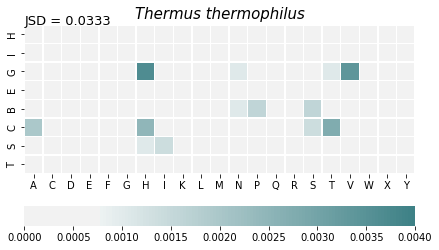

In [ ]:
plot_jsd_heatmap(protein_SS_df.loc['Thermus thermophilus', 'JSD8_matrix'], 'Thermus thermophilus')

# Statistical analysis

We will use permutation to test whether JS divergence values are from the same distribution. To do that we will create artifitial AA / SS sequences using all original AA / SS sequences. We will create 10,000 sequences of 1000 residues long by resampling original data with replacement

As all Data files are of different lengths, we will have to resample each datafile individually first and only then concatenate the results

We will also need to use the same positions for each native, recombinant, AA and SS sequence. To do that for each resampling event, we will first create a list of random integers (with replacement, from 0 to length of the corresponding sequence) and use that list to resample from each sequence

In order to speed up the process, we will not really create resampled sequences, but instead will directly create count matrices that will be used to calculate JS divergence. We will add up count matrices from each resample to "concatenate" and then calculate JS divergence (using 8 and 3 SS types)

In [26]:
[*map(len, protein_SS_df.loc[:, 'AA_native'])]

[2225, 10354, 7971, 5397, 1273, 11303, 6591, 4926]

In [27]:
[*map(len, protein_SS_df.loc[:, 'AA_recomb'])]

[303441, 12921, 40167, 52016, 163888, 234768, 4265, 308608]

In [35]:
species = 'Thermus thermophilus'
size = 100

AA_seq = protein_SS_df.loc[species, 'AA_native']
SS_seq = protein_SS_df.loc[species, 'SS_native']

seq_len = len(AA_seq)

resampled_sequence_positions = np.random.randint(0, seq_len, size=size)
AA_resampled = ''.join([AA_seq[i] for i in resampled_sequence_positions])
SS_resampled = ''.join([SS_seq[i] for i in resampled_sequence_positions])

CCHCHHHCHSTCCHSHSCTSHCHHHHCHEHHSHHHCHCCCHBHHHHTECTTHGTHHHHECHHHHHGHCHECTCTHCCEHGGCSHSHHCHHHCEHCGCHCH


In [41]:
def simple_datafile_resample(AA_seq, SS_seq, length):
  resampled_sequence_positions = np.random.randint(0, len(AA_seq), size=length)
  AA_resampled = ''.join([AA_seq[i] for i in resampled_sequence_positions])
  SS_resampled = ''.join([SS_seq[i] for i in resampled_sequence_positions])
  return AA_resampled, SS_resampled

In [ ]:
size = 1000
length = 1000

JSD8_resampled = {}
JSD3_resampled = {}

for species in tqdm(species_names):
  JSD8_list = []
  JSD3_list = []
  for i in tqdm(range(size)):
    native = simple_datafile_resample(AA_seq=protein_SS_df.loc[species, 'AA_native'], SS_seq=protein_SS_df.loc[species, 'SS_native'], length=length)
    recomb = simple_datafile_resample(AA_seq=protein_SS_df.loc[species, 'AA_recomb'], SS_seq=protein_SS_df.loc[species, 'SS_recomb'], length=length)
    CM8_native = get_count_matrix(native[0], native[1])
    CM8_recomb = get_count_matrix(recomb[0], recomb[1])
    JSD8 = np.sum(calculate_JS_matrix(CM8_native, CM8_recomb))
    JSD8_list.append(JSD8)
    CM3_native = change_to_SS3(CM8_native)
    CM3_recomb = change_to_SS3(CM8_recomb)
    JSD3 = np.sum(calculate_JS_matrix(CM3_native, CM3_recomb))
    JSD3_list.append(JSD3)
  JSD8_resampled[species] = JSD8_list
  JSD3_resampled[species] = JSD3_list

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log2
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':

 10%|█         | 101/1000 [00:25<03:40,  4.08it/s]

In [ ]:
pd.DataFrame(JSD8_resampled).plot(kind='box')

In [ ]:
pd.DataFrame(JSD3_resampled).plot(kind='box')

In [ ]:
def resample_seqs_to_CMs(species, df=protein_SS_df, seq_len=1000):

  size = int(seq_len / len(species))

  final_CM1 = pd.DataFrame(0, columns=AA_types, index=SS8_types)
  final_CM2 = pd.DataFrame(0, columns=AA_types, index=SS8_types)

  for s in species:
    
    AA_seqs = (df.loc[s, 'AA_native'], df.loc[s, 'AA_recomb'])
    SS_seqs = (df.loc[s, 'SS_native'], df.loc[s, 'SS_recomb'])

    resampled_sequence_positions = np.random.randint(0, len(AA_seqs[0]), size=size)

    AA_seq1 = np.array([*AA_seqs[0]])[resampled_sequence_positions]
    AA_seq2 = np.array([*AA_seqs[1]])[resampled_sequence_positions]
    SS_seq1 = np.array([*SS_seqs[0]])[resampled_sequence_positions]
    SS_seq2 = np.array([*SS_seqs[1]])[resampled_sequence_positions]

    counts1 = np.array([np.sum([aa==AA and ss==SS for aa, ss in zip(AA_seq1, SS_seq1)]) \
                      for SS in SS8_types for AA in AA_types]).reshape((len(SS8_types),len(AA_types)))

    CM1 = pd.DataFrame(counts1, columns=AA_types, index=SS8_types)

    counts2 = np.array([np.sum([aa==AA and ss==SS for aa, ss in zip(AA_seq2, SS_seq2)]) \
                      for SS in SS8_types for AA in AA_types]).reshape((len(SS8_types),len(AA_types)))

    CM2 = pd.DataFrame(counts2, columns=AA_types, index=SS8_types)

    final_CM1 += CM1
    final_CM2 += CM2

  
  return final_CM1, final_CM2

In [ ]:
resampled_data = pd.DataFrame()
resampled_data['CM8s'] = [*map(resample_seqs_to_CMs, tqdm([protein_SS_df.index]*10000))]
resampled_data[['CM8_native', 'CM8_recomb']] = pd.DataFrame(resampled_data.CM8s.tolist())
resampled_data['CM3_native'] = [*map(change_to_SS3, resampled_data['CM8_native'])]
resampled_data['CM3_recomb'] = [*map(change_to_SS3, resampled_data['CM8_recomb'])]
resampled_data['JSD8_matrix'] = [*map(calculate_JS_matrix, resampled_data['CM8_native'], resampled_data['CM8_recomb'])]
resampled_data['JSD3_matrix'] = [*map(calculate_JS_matrix, resampled_data['CM3_native'], resampled_data['CM3_recomb'])]
resampled_data['JSD8'] = [*map(np.sum, resampled_data['JSD8_matrix'])]
resampled_data['JSD3'] = [*map(np.sum, resampled_data['JSD3_matrix'])]

  0%|          | 0/10000 [00:00<?, ?it/s]


IndexError: ignored

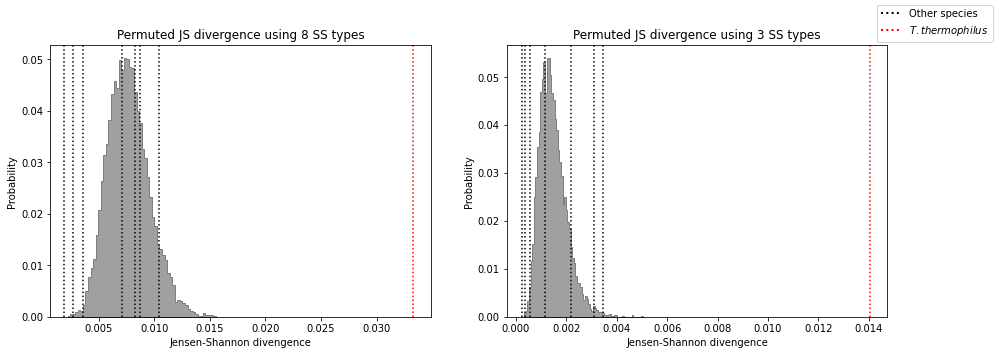

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

ax[0].title.set_text('Permuted JS divergence using 8 SS types')
ax[0].set_xlabel('Jensen-Shannon divengence')
sns.histplot(resampled_data.JSD8, element='step', stat='probability', color='gray', ax=ax[0])
ax[0].axvline(x=protein_SS_df.loc['Thermus thermophilus', 'JSD8'], c='red', linestyle=':')
for species in species_names[:-1]:
  ax[0].axvline(x=protein_SS_df.loc[species, 'JSD8'], c='black', linestyle=':')

ax[1].title.set_text('Permuted JS divergence using 3 SS types')
ax[1].set_xlabel('Jensen-Shannon divengence')
sns.histplot(resampled_data.JSD3, element='step', stat='probability', color='gray', ax=ax[1])
ax[1].axvline(x=protein_SS_df.loc['Thermus thermophilus', 'JSD3'], c='red', linestyle=':', label='T. thermophilus')
for species in species_names[:-1]:
  ax[1].axvline(x=protein_SS_df.loc[species, 'JSD3'], c='black', linestyle=':', label='Other species')

colors = ['black', 'red']
lines = [Line2D([0], [0], color=c, linewidth=2, linestyle=':') for c in colors]
labels = ['Other species', '$\it{T. thermophilus}$']
plt.figlegend(lines, labels, loc='upper right')

plt.show()
fig.savefig('JSD_permutation.jpg')
files.download('JSD_permutation.jpg')

In [ ]:
np.quantile(resampled_data.JSD8, [0.05, 0.95])

array([0.00489042, 0.01102528])

In [ ]:
np.quantile(resampled_data.JSD3, [0.05, 0.95])

array([0.00073837, 0.00247025])

In [ ]:
JSD8_confidence = pd.DataFrame({'JSD8':protein_SS_df.JSD8,
                                'p-value':[np.sum(resampled_data.JSD8 >= jsd_actual) / len(resampled_data.JSD8) \
                                           for jsd_actual in protein_SS_df.JSD8]})
JSD8_confidence

,JSD8,p-value
Bacillus subtilis,0.010411,0.0823
Desulfovibrio vulgaris,0.008291,0.3427
Lactococcus lactis,0.007105,0.5942
Pseudomonas fluorescens,0.008700,0.2702
Pseudomonas putida,0.001878,1.0000
Salmonella enterica,0.002733,0.9993
Streptomyces rubiginosus,0.003569,0.9954
Thermus thermophilus,0.033324,0.0000


In [ ]:
JSD3_confidence = pd.DataFrame({'JSD3':protein_SS_df.JSD3,
                                'p-value':[np.sum(resampled_data.JSD3 >= jsd_actual) / len(resampled_data.JSD3) \
                                           for jsd_actual in protein_SS_df.JSD3]})
JSD3_confidence

,JSD3,p-value
Bacillus subtilis,0.001135,0.6971
Desulfovibrio vulgaris,0.003449,0.0039
Lactococcus lactis,0.003086,0.0115
Pseudomonas fluorescens,0.002172,0.1009
Pseudomonas putida,0.000241,1.0000
Salmonella enterica,0.000351,0.9998
Streptomyces rubiginosus,0.000551,0.9919
Thermus thermophilus,0.014054,0.0000


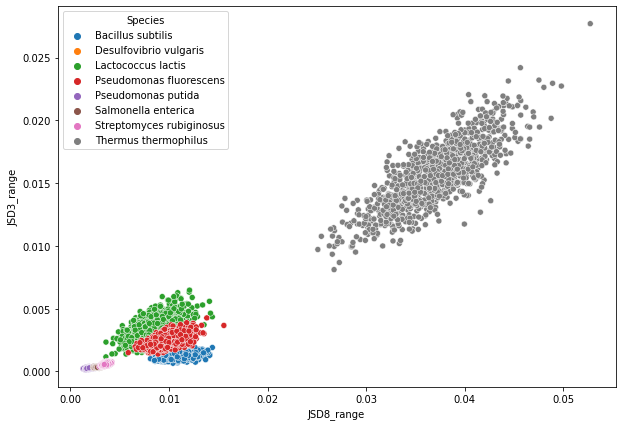

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(x='JSD8_range', y='JSD3_range', hue='Species', data=ci_df_long)
plt.show()

In [ ]:
ci_df_long

,Species,JSD8_range,JSD3_range
0,Bacillus subtilis,0.0117132,0.000884927
1,Bacillus subtilis,0.00951636,0.00108374
2,Bacillus subtilis,0.0097394,0.00124249
3,Bacillus subtilis,0.0112294,0.00125701
4,Bacillus subtilis,0.0110401,0.000883252
...,...,...,...
7995,Thermus thermophilus,0.0360271,0.0160445
7996,Thermus thermophilus,0.0436216,0.0172202
7997,Thermus thermophilus,0.0404005,0.0149781
7998,Thermus thermophilus,0.0355569,0.0151555


We can also estimate confidence intervals (CI) for each JS divergence that we calculated previously for the "real" data. To do that we will use each species individually to create resampled datafiles of the same size as the original datafiles. After that we can use the resampled datafiles to calculate CI

In [ ]:
n = 1000

for i, species in enumerate(['Streptomyces rubiginosus']):
  print(i+1, ':', species)
  name = species.replace(' ', '_') + '_resampledJSDs.npy'
  l = len(protein_SS_df.loc[species, 'AA_native'])
  CM8_list = [*map(resample_seqs_to_CMs, tqdm([[species]]*n), [protein_SS_df]*n, [l]*n)]
  CM3_list = [(change_to_SS3(m1), change_to_SS3(m2)) for m1, m2 in CM8_list]
  JSM8_list = [calculate_JS_matrix(m1, m2) for m1, m2 in CM8_list]
  JSM3_list = [calculate_JS_matrix(m1, m2) for m1, m2 in CM3_list]
  JSD8_values = np.array([np.sum(jsm) for jsm in JSM8_list])
  JSD3_values = np.array([np.sum(jsm) for jsm in JSM3_list])
  with open(name, 'wb') as f:
    np.save(f, JSD8_values)
    np.save(f, JSD3_values)
  files.download(name)

1 : Streptomyces rubiginosus


100%|██████████| 1000/1000 [3:42:19<00:00, 13.34s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log2
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
ci_df = pd.DataFrame(index=protein_SS_df.index, columns=['JSD8_range', 'JSD3_range'])
file_names = ['/content/Bacillus_subtilis_resampledJSDs.npy',
              '/content/Desulfovibrio_vulgaris_resampledJSDs.npy',
              '/content/Lactococcus_lactis_resampledJSDs.npy',
              '/content/Pseudomonas_fluorescens_resampledJSDs.npy',
              '/content/Pseudomonas_putida_resampledJSDs.npy',
              '/content/Salmonella_enterica_resampledJSDs.npy',
              '/content/Streptomyces_rubiginosus_resampledJSDs.npy',
              '/content/Thermus_thermophilus_resampledJSDs.npy']

for species, file_name in zip(ci_df.index, file_names):
  with open(file_name, 'rb') as f:
    ci_df.loc[species, 'JSD8_range'] = np.load(f)
    ci_df.loc[species, 'JSD3_range'] = np.load(f)

In [ ]:
ci_df

,JSD8_range,JSD3_range
Bacillus subtilis,"[0.011713179546810115, 0.009516360002821262, 0...","[0.0008849274951518754, 0.001083735176318384, ..."
Desulfovibrio vulgaris,"[0.008569956915403399, 0.008601729210010721, 0...","[0.0035308425846182307, 0.0036804969428611534,..."
Lactococcus lactis,"[0.01037479057270449, 0.006783594917383462, 0....","[0.0056241846816539615, 0.0036888970705006748,..."
Pseudomonas fluorescens,"[0.009846184190195013, 0.010653854437711482, 0...","[0.0019837799843721764, 0.002944872121742647, ..."
Pseudomonas putida,"[0.002027282911973732, 0.0018218732366399831, ...","[0.0002806542292384058, 0.0002580849198510637,..."
Salmonella enterica,"[0.0025280982818551984, 0.0027977920599121867,...","[0.0003095937178522136, 0.00033356796158177314..."
Streptomyces rubiginosus,"[0.0037972281482802047, 0.003673494483434652, ...","[0.0005286158208172415, 0.0005361488937236896,..."
Thermus thermophilus,"[0.036549222876091164, 0.04014918151742442, 0....","[0.016046160101434573, 0.016560687684367147, 0..."


In [ ]:
ci_df_long = pd.DataFrame()

ci_df_long['JSD8_range'] = ci_df.JSD8_range.explode()
ci_df_long['JSD3_range'] = ci_df.JSD3_range.explode()
ci_df_long = ci_df_long.rename_axis('Species').reset_index()

In [ ]:
ci_df_long.to_pickle('ci_df_long.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

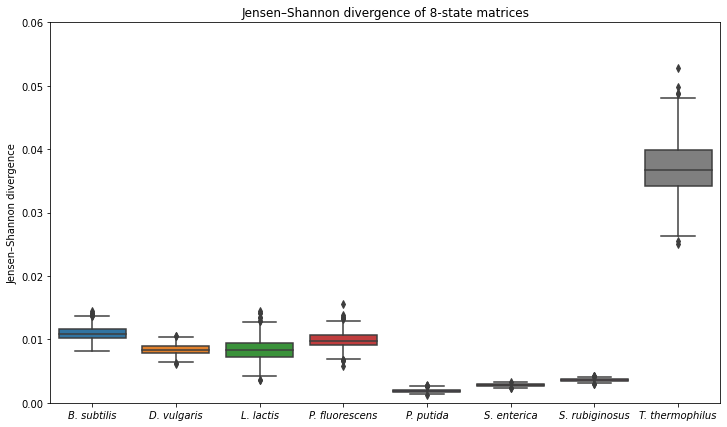

In [ ]:
fig, ax = plt.subplots(figsize = (12, 7))
fig = sns.boxplot(data=ci_df_long, x='Species', y='JSD8_range')
fig.set_xlabel('')
fig.set_ylabel('Jensen–Shannon divergence')
fig.set_title('Jensen–Shannon divergence of 8-state matrices')
fig.set_xticklabels(species_names_veryshort, style = 'italic')

plt.ylim([0,0.06])

ax.get_figure().savefig('08_JSD8_boxplot.png')
files.download('08_JSD8_boxplot.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

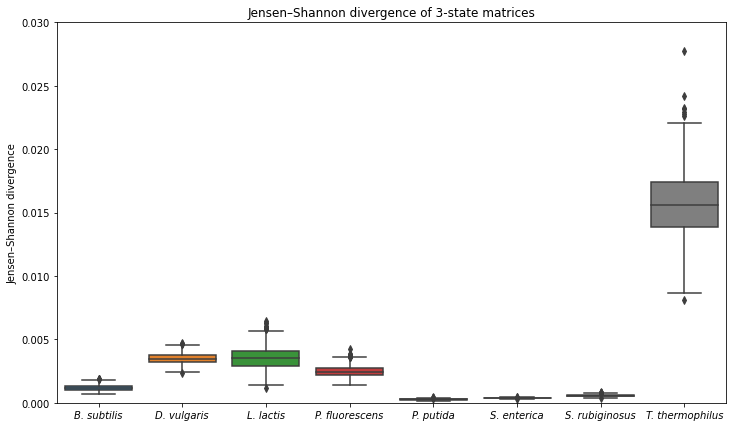

In [ ]:
fig, ax = plt.subplots(figsize = (12, 7))
fig = sns.boxplot(data=ci_df_long, x='Species', y='JSD3_range')
fig.set_xlabel('')
fig.set_ylabel('Jensen–Shannon divergence')
fig.set_title('Jensen–Shannon divergence of 3-state matrices')
fig.set_xticklabels(species_names_veryshort, style = 'italic')

plt.ylim([0,0.03])

ax.get_figure().savefig('08_JSD3_boxplot.png')
files.download('08_JSD3_boxplot.png')